# Test the L3 market state class

In [1]:
# -- last update: 05.September 2022

In [1]:
# Questions:
# - Why is snapshot_start in a list and snapshot_end not?
# - Why do most packets have 2 messages and some more (mostly 3), is there a certain pattern?
# - Why is the first message packet so long (in order to reconstuct state when trading period starts)?
# - 13005 = TemplateID for the Packet Header (?), later updated to 13004...
# - What exactly does "implied trade" mean (TradeCondition in execution summary)?
# - flawed message (AggressorTime': None) braks code
# - 'flags': 'TXN'?
# - A message packet can contain various timestamps in different messages and even in the same message, wich
# timestamp is most suited as 'global timestamp' for the simulator? For the simulation, the agent view is 
# especially relevant which should be the packet header timestamp (and even plus some latency?)

In [2]:
import numpy as np
import pandas as pd
import json
import time
import cProfile
import os
from deepdiff import DeepDiff
from timeit import default_timer as timer
import matplotlib.pyplot as plt

In [3]:
os.getcwd()

'/Users/florianewald/PycharmProjects/Level3-Data-Analysis/L3_library_own_version'

### Load Data

In [4]:
# import State
from environment.market_state_new import MarketStateAttribute
# import Parser
from environment.parser_new import SnapshotParser, MessagePacketParser
%load_ext autoreload
%autoreload 2

In [5]:
# path to sample data directory
#path = "/Users/florianewald/PycharmProjects/Level3-Data-Analysis/sample_msg_data/DE0005190003.XETR_20220201T120211_20220201T163000"
#path = "/Users/florianewald/PycharmProjects/Level3-Data-Analysis/sample_msg_data/DE0005190003.XETR_20220201T080007_20220201T120000"
path = "/Users/florianewald/PycharmProjects/Level3-Data-Analysis/sample_msg_data/DE0005190003.XETR_20220202T080014_20220202T120000"

In [6]:
def load_data(path):
    start = timer()
    # load snapshot start
    file = open(f"{path}/snapshot_start.json")
    snapshot_start = json.load(file)
    
    # load snapshot end
    file = open(f"{path}/snapshot_end.json")
    snapshot_end = json.load(file)

    # load message list
    file = open(f"{path}/message_list.json")
    message_list = json.load(file)
    end = timer()
    print('loading time: ', round(end-start, 2), 'seconds')
    return snapshot_start, snapshot_end, message_list

In [7]:
snapshot_start, snapshot_end, message_list = load_data(path=path)
message_list = message_list[1:]

loading time:  2.48 seconds


### Inspect Data

#### 1. Snapshots

In [8]:
# typical snapshot representation:
#{'MarketID': 'XETR',
#  'MarketSegmentID': 52807,
#  'SecurityID': '2504900',
#  'Timestamp': '1643716931606014831',
#  'TransactTime': '1643716931606651813',
#  'prev': '1643716800165014545',
#  'next': '1643716931606681391',
#  'Buy': [{'Price': '...', 'Quantity':'...', 'Orders': ['TemplateID'...]}] # for each level
#  'Sell': [{'Price': '...', 'Quantity':'...', 'Orders': ['TemplateID'...]}] # for each level

In [9]:
snapshot_start

[{'MarketID': 'XETR',
  'MarketSegmentID': 52807,
  'SecurityID': '2504900',
  'Timestamp': '1643788814331017219',
  'TransactTime': '1643788814332114986',
  'next': '1643788814332158149',
  'Buy': [{'Price': '9430000000',
    'Quantity': '720000',
    'OrderCount': 2,
    'Orders': [{'TemplateID': 13100,
      'MsgSeqNum': 273,
      'TrdRegTSTimePriority': '1643783574040851358',
      'DisplayQty': '20000'},
     {'TemplateID': 13100,
      'MsgSeqNum': 275,
      'TrdRegTSTimePriority': '1643787913879570010',
      'DisplayQty': '700000'}]},
   {'Price': '9429000000',
    'Quantity': '980000',
    'OrderCount': 4,
    'Orders': [{'TemplateID': 13100,
      'MsgSeqNum': 277,
      'TrdRegTSTimePriority': '1643783750925163962',
      'DisplayQty': '850000'},
     {'TemplateID': 13100,
      'MsgSeqNum': 279,
      'TrdRegTSTimePriority': '1643787000060827415',
      'DisplayQty': '60000'},
     {'TemplateID': 13100,
      'MsgSeqNum': 281,
      'TrdRegTSTimePriority': '16437876747577

In [10]:
print('dtype snapshot: ', type(snapshot_start))
print('len: ', len(snapshot_start))

dtype snapshot:  <class 'list'>
len:  1


In [11]:
# snapshot_start is a list which contains only one element -> the snapshot dict
type(snapshot_start[0])

dict

In [12]:
snapshot_start[0].keys()

dict_keys(['MarketID', 'MarketSegmentID', 'SecurityID', 'Timestamp', 'TransactTime', 'next', 'Buy', 'Sell'])

In [13]:
# snapshot contains some meta information
meta_keys = ['MarketID',
 'MarketSegmentID',
'SecurityID',
'Timestamp',
'TransactTime',
'prev',
'next']

for key in meta_keys:
    print(snapshot_start[0].get(key))

XETR
52807
2504900
1643788814331017219
1643788814332114986
None
1643788814332158149


In [14]:
# also contains all levels of orders for buy and sell side
side_keys = ['Buy', 'Sell']
for key in side_keys:
    print(key)
    print('both sides contain a list:')
    print('type: ', type(snapshot_start[0][key]))
    print('the list contains a number of dicts:')
    print('type: ', type(snapshot_start[0][key][0]))
    print('numer of price levels: ',len(snapshot_start[0].get(key)))
    print('Each price level dict contains the following keys/elements:')
    print(snapshot_start[0]['Buy'][0].keys())
    print('If one price level has several orders, each order is represented as dict in the Order-list:')
    print('-- Each order dict has the following keys/elements:')
    print(snapshot_start[0]['Buy'][100]['Orders'][0].keys())

Buy
both sides contain a list:
type:  <class 'list'>
the list contains a number of dicts:
type:  <class 'dict'>
numer of price levels:  216
Each price level dict contains the following keys/elements:
dict_keys(['Price', 'Quantity', 'OrderCount', 'Orders'])
If one price level has several orders, each order is represented as dict in the Order-list:
-- Each order dict has the following keys/elements:
dict_keys(['TemplateID', 'MsgSeqNum', 'TrdRegTSTimePriority', 'DisplayQty'])
Sell
both sides contain a list:
type:  <class 'list'>
the list contains a number of dicts:
type:  <class 'dict'>
numer of price levels:  211
Each price level dict contains the following keys/elements:
dict_keys(['Price', 'Quantity', 'OrderCount', 'Orders'])
If one price level has several orders, each order is represented as dict in the Order-list:
-- Each order dict has the following keys/elements:
dict_keys(['TemplateID', 'MsgSeqNum', 'TrdRegTSTimePriority', 'DisplayQty'])


In [15]:
# snapshot end has the same format (but why is it not inside a list???)
print(len(snapshot_end['Buy']))
print(len(snapshot_end['Sell']))

291
250


#### 2. Messages

In [16]:
print('number of elements in message list: ',len(message_list))

number of elements in message list:  390268


In [17]:
print('The elements inside message_lists are also lists')
print('type: ', type(message_list[0]))
print('...these lists are message packets which can contain several messages as dicts')

The elements inside message_lists are also lists
type:  <class 'list'>
...these lists are message packets which can contain several messages as dicts


In [18]:
# len of first element
len(message_list[0])

2

In [19]:
# TODO: why does the first element have so many messages? 
# Is this to "reconstruct" the entire orderbook insteaqd of using a snapshot after the night?
# If so, we can jsut exclude the first element and start with the second one...

In [20]:
def analyse_msg_data(message_list):
    packet_len_list = []
    for i in range(len(message_list)):
        packet_len = len(message_list[i])
        packet_len_list.append(packet_len)

    print('max packet len:                  ', max(packet_len_list))
    print('min packet len:                  ', min(packet_len_list))
    print('mean packet len:                 ', sum(packet_len_list)/len(packet_len_list))
    print('how often is len equal to 2:     ', sum([x == 2 for x in packet_len_list]))
    print('how often is len smaller than 2: ', sum([x < 2 for x in packet_len_list]))
    print('how often is len smaller than 2: ', sum([x > 2 for x in packet_len_list]))
    
    # plot histogram of outliers
    lower_limit = 2
    upper_limit = 20
    filterbool = [x > lower_limit and x < upper_limit for x in packet_len_list]
    arr = np.array(packet_len_list)[filterbool]
    list1 = arr.tolist()
    plt.hist(list1[1:], bins=(upper_limit*2));
    plt.title('distribution of outliers [leaving out extreme outliers]')
    plt.xticks(np.arange(upper_limit),rotation = 90)
    plt.show()

max packet len:                   40
min packet len:                   2
mean packet len:                  2.0137239025490175
how often is len equal to 2:      387432
how often is len smaller than 2:  0
how often is len smaller than 2:  2836


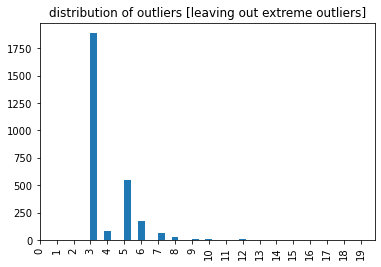

In [21]:
analyse_msg_data(message_list=message_list)

**template_id**  <p>
13100 (order_add), <p>
13101 (order_modify), <p>
13102 (order_delete),<p>
13103 (order_mass_delete), <p>
13104 (execution_full), <p>
13105 (execution_partial),<p>
13106 (order_modify_same_priority), <p>
13202 (execution_summary),<p>
99999 (order_submit agent-side), <p>
66666 (order_cancel agent-side)<p>

In [22]:
template_id_legend = {13100: 'order_add',
13101: 'order_modify',
13102: 'order_delete',
13103: 'order_mass_delete',
13104: 'execution_full',
13105: 'execution_partial',
13106: 'order_modify_same_priority',
13202: 'execution_summary'}
#99999 (order_submit agent-side), <p>
#66666 (order_cancel agent-side)<p>

In [23]:
template_id_legend

{13100: 'order_add',
 13101: 'order_modify',
 13102: 'order_delete',
 13103: 'order_mass_delete',
 13104: 'execution_full',
 13105: 'execution_partial',
 13106: 'order_modify_same_priority',
 13202: 'execution_summary'}

In [24]:
# standard message packet consist of two messages:
# 'TemplateID': 13005 =>
# 'TemplateID': 13100 => 
message_list[1]

[{'MessageHeader': {'BodyLen': 32, 'TemplateID': 13005, 'MsgSeqNum': None},
  'ApplSeqNum': 48020,
  'MarketSegmentID': 52807,
  'PartitionID': 53,
  'CompletionIndicator': 1,
  'ApplSeqResetIndicator': 0,
  'TransactTime': '1643788814332262374',
  'flags': 'TXN'},
 {'MessageHeader': {'BodyLen': 56, 'TemplateID': 13100, 'MsgSeqNum': 1219},
  'TrdRegTSTimeIn': '1643788814332136931',
  'SecurityID': '2504900',
  'OrderDetails': {'TrdRegTSTimePriority': '1643788814332172988',
   'DisplayQty': '700000',
   'Side': 1,
   'OrdType': None,
   'Price': '9431000000'}}]

| Explanation of "Base Message" |                                                                                                                       |
|-------------------------------|-----------------------------------------------------------------------------------------------------------------------|
| **FieldName**                     | **Description**                                                                                                           |
| MessageHeader                 |                                                                                                                       |
| BodyLen                       | Number of bytes for the message                                                                                       |
| TemplateID                    | Unique identifier for a T7 EOBI message layout, always 13005(?)                                                       |
| MsgSeqNum                     | not used                                                                                                              |
| ApplSeqNum                    | Message sequence number is contiguous and is incremented across products                                              |
| MarketSegmentID               | Product identifier                                                                                                    |
| PartitionID                   | Grouping of T7 products. Belongs to the scope of Service Avail- ability                                               |
| CompletionIndicator           | Indicated whether an unit of works fits into a single datagram for incremental messages. 0 = incomplete, 1 = complete |
| ApplSeqResetIndicator         | 0 = No Rest, 1 = Rest                                                                                                 |
| TransactTime                  | Time when market data feed handler writes packet on the wire.                                                         |
| flags                         | ?     

| Explanation of a Sample Message |                                                                              |
|---------------------------------|------------------------------------------------------------------------------|
| <MessageHeader>                 |                                                                              |
| BodyLen                         | Number of bytes for the message                                              |
| TemplateID                      | Unique identifier for a T7 EOBI message layout, 13100 [=> 'order add'])      |
| MsgSeqNum                       | Message sequence number, incre- mented per product across all message types. |
| TrdRegTSTimeIn                  | Gateway-In timestamp.                                                        |
| SecurityID                      | Unique instrument identifier.                                                |
| <OrderDetails>                  |                                                                              |
| TrdRegTSTimePriority            | Priority timestamp.                                                          |
| DisplayQty                      | Quantity                                                                     |
| Side                            | 1: Buy, 2: Sell                                                              |
| OrdType                         | 1 = Market Order Used for cash market instruments only. (None?)              |
| Price                           | Price  

In [25]:
# collect all templateIDs in a list
all_template_ids = []
for i, message_packet in enumerate(message_list[1:]):
    #print(len(message_packet))
    for message in message_packet:
        #print(message['MessageHeader']['TemplateID'])
        templateID = message['MessageHeader']['TemplateID']
        all_template_ids.append(templateID)

In [26]:
# Count the distribution of templateIDs over entire trading period

print('TemplateID Occurances:')
from collections import Counter
counter = dict(Counter(all_template_ids))

# add legend to counter object:
def append_value(dict_obj, key, value):
    # Check if key exist in dict or not
    if key in dict_obj:
        # Key exist in dict.
        # Check if type of value of key is list or not
        if not isinstance(dict_obj[key], list):
            # If type is not list then make it list
            dict_obj[key] = [dict_obj[key]]
        # Append the value in list
        dict_obj[key].append(value)
    else:
        # As key is not in dict,
        # so, add key-value pair
        dict_obj[key] = value

for key in counter.keys():
    #print(key)
    dict_obj = counter
    key = key
    if key in template_id_legend.keys():
        value = template_id_legend[key]
        append_value(dict_obj, key, value)
    else:
        append_value(dict_obj, key, 'NOT DEFINED')

counter

TemplateID Occurances:


{13005: [391130, 'NOT DEFINED'],
 13100: [182325, 'order_add'],
 13102: [178464, 'order_delete'],
 13101: [22390, 'order_modify'],
 13202: [2834, 'execution_summary'],
 13104: [3480, 'execution_full'],
 13106: [4418, 'order_modify_same_priority'],
 13105: [849, 'execution_partial']}

In [27]:
# check if templateID 13005 is included in EACH message packet:
for i, message_packet in enumerate(message_list[1:]):
    current_templateIDs = []
    for message in message_packet:
        templateID = message['MessageHeader']['TemplateID']
        current_templateIDs.append(templateID)
    if 13005 not in current_templateIDs:
        print(message_packet)

In [28]:
# analyse body length:
all_body_lengths = []
for i, message_packet in enumerate(message_list[1:]):

    for message in message_packet:
        body_len = message['MessageHeader']['BodyLen']
        template_id = message['MessageHeader']['TemplateID']
        all_body_lengths.append([body_len, template_id])
#dict(Counter(all_body_lengths))

In [29]:
print('Body Lengths and corresponding Template IDs:')
body_lens = [32, 56, 64, 80,72]
for body_len in body_lens:

    arr = np.array(all_body_lengths)
    mask = arr[:,0] == body_len
    arr1 = arr[mask][:,1]
    # check if all elements are the same
    result = np.max(arr1) == np.min(arr1)
    info = np.unique(arr1)
    print(body_len, 'unique_id: ',result, 'template_IDs: ', info)

Body Lengths and corresponding Template IDs:
32 unique_id:  True template_IDs:  [13005]
56 unique_id:  False template_IDs:  [13100 13104 13105]
64 unique_id:  True template_IDs:  [13102]
80 unique_id:  False template_IDs:  [13101 13202]
72 unique_id:  True template_IDs:  [13106]


In [30]:
# There are only 5 different body_lengths:
# 32: Standard message (13005)
# 56: order add (13100), execution full (13104), execution partial (13105)
# 64: order delete (13102)
# 80: order modify (13101), execution summary (13202)
# 72: order_modify_same_priority (13106)
# => order mass delete did not occur in the sample dataset (could be rare, I think only after market interruptions)

#### Analyse Message Packet Lengths

In [31]:
# analyse packet length:
all_pkt_lengths = []
for i, message_packet in enumerate(message_list[1:]):
    template_ids = []
    length = len(message_packet)
    all_pkt_lengths.append(length)

In [32]:
Counter(all_pkt_lengths)

Counter({2: 387431,
         3: 1891,
         7: 66,
         5: 547,
         6: 178,
         8: 32,
         12: 6,
         4: 82,
         9: 13,
         10: 7,
         40: 1,
         13: 3,
         11: 4,
         25: 1,
         15: 2,
         36: 1,
         14: 1,
         19: 1})

In [33]:
# analyse packet length:
all_msg_lengths = []
for i, message_packet in enumerate(message_list[1:]):
    template_ids = []
    length = len(message_packet)

    template_ids.append(length)
    for message in message_packet:

        template_id = message['MessageHeader']['TemplateID']
        template_ids.append(template_id)
        
    all_msg_lengths.append(template_ids)

In [34]:
all_msg_lengths

[[2, 13005, 13100],
 [2, 13005, 13100],
 [2, 13005, 13100],
 [2, 13005, 13100],
 [2, 13005, 13100],
 [2, 13005, 13100],
 [2, 13005, 13100],
 [2, 13005, 13102],
 [2, 13005, 13100],
 [2, 13005, 13100],
 [2, 13005, 13100],
 [2, 13005, 13100],
 [2, 13005, 13102],
 [2, 13005, 13101],
 [2, 13005, 13100],
 [2, 13005, 13100],
 [2, 13005, 13102],
 [2, 13005, 13100],
 [2, 13005, 13100],
 [2, 13005, 13102],
 [2, 13005, 13101],
 [2, 13005, 13100],
 [2, 13005, 13100],
 [2, 13005, 13100],
 [2, 13005, 13100],
 [2, 13005, 13100],
 [3, 13005, 13202, 13104],
 [2, 13005, 13100],
 [2, 13005, 13102],
 [2, 13005, 13100],
 [2, 13005, 13100],
 [2, 13005, 13101],
 [2, 13005, 13102],
 [2, 13005, 13100],
 [2, 13005, 13100],
 [2, 13005, 13101],
 [2, 13005, 13101],
 [2, 13005, 13102],
 [2, 13005, 13102],
 [2, 13005, 13101],
 [2, 13005, 13101],
 [2, 13005, 13101],
 [2, 13005, 13100],
 [2, 13005, 13100],
 [3, 13005, 13202, 13104],
 [2, 13005, 13100],
 [2, 13005, 13100],
 [2, 13005, 13100],
 [2, 13005, 13101],
 [2, 1

In [35]:
arr2 = np.array(all_msg_lengths)

/var/folders/01/m_5nvn8562j72ty3_7sm3hd40000gn/T/ipykernel_16454/3990059963.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr2 = np.array(all_msg_lengths)


In [36]:
# TODO: Analyse deeper... (e.g. which templateIDs can be associated with which number of messages etc.)

#### Analyze timestamps

In [37]:
message_list[1]

[{'MessageHeader': {'BodyLen': 32, 'TemplateID': 13005, 'MsgSeqNum': None},
  'ApplSeqNum': 48020,
  'MarketSegmentID': 52807,
  'PartitionID': 53,
  'CompletionIndicator': 1,
  'ApplSeqResetIndicator': 0,
  'TransactTime': '1643788814332262374',
  'flags': 'TXN'},
 {'MessageHeader': {'BodyLen': 56, 'TemplateID': 13100, 'MsgSeqNum': 1219},
  'TrdRegTSTimeIn': '1643788814332136931',
  'SecurityID': '2504900',
  'OrderDetails': {'TrdRegTSTimePriority': '1643788814332172988',
   'DisplayQty': '700000',
   'Side': 1,
   'OrdType': None,
   'Price': '9431000000'}}]

In [38]:
message_list[500]

[{'MessageHeader': {'BodyLen': 32, 'TemplateID': 13005, 'MsgSeqNum': None},
  'ApplSeqNum': 49181,
  'MarketSegmentID': 52807,
  'PartitionID': 53,
  'CompletionIndicator': 1,
  'ApplSeqResetIndicator': 0,
  'TransactTime': '1643788815375453206',
  'flags': 'TXN'},
 {'MessageHeader': {'BodyLen': 80, 'TemplateID': 13101, 'MsgSeqNum': 1765},
  'TrdRegTSTimeIn': '1643788815375436745',
  'TrdRegTSPrevTimePriority': '1643788814333112442',
  'PrevPrice': '9557000000',
  'PrevDisplayQty': '10600000',
  'SecurityID': '2504900',
  'OrderDetails': {'TrdRegTSTimePriority': '1643788815375444359',
   'DisplayQty': '10600000',
   'Side': 2,
   'OrdType': None,
   'Price': '9556000000'}}]

In [39]:
# => There are many different timestamps, which one is most suited for "global timestamp"?

In [40]:
# Does each message contain a TemplateID 13005 (standard message)?
standard_ids = []
standard_times = []
for message_paket in message_list[1:]:
    
    standard_id = message_paket[0]['MessageHeader']['TemplateID']
    standard_ids.append(standard_id)
    if standard_id != 13005:
        print(message_paket[0])
    standard_time = message_paket[0]['TransactTime']
    standard_times.append(standard_time)

In [41]:
len(standard_ids)

390267

In [42]:
len(message_list[1:])

390267

In [43]:
len(standard_times)

390267

In [44]:
# TODO: Check if this is also true for other datasets... not just by chance...

In [45]:
for message_packet in message_list[1:50]:
    
    for message in message_packet:
        #print(message.keys())
        if 'TransactTime' in message.keys():
            print(message['TransactTime'])
        elif 'TrdRegTSTimeIn' in message.keys():
            print(message['TrdRegTSTimeIn'])
            
        else:
            print(message)

1643788814332262374
1643788814332136931
1643788814332422003
1643788814332378463
1643788814332429878
1643788814332383269
1643788814332480294
1643788814332433497
1643788814332486475
1643788814332443063
1643788814332548867
1643788814332521453
1643788814332584363
1643788814332562015
1643788814332614194
1643788814332579491
1643788814332621916
1643788814332570335
1643788814332625699
1643788814332575257
1643788814332640410
1643788814332610733
1643788814332703196
1643788814332653555
1643788814332715024
1643788814332695583
1643788814332782869
1643788814332684673
1643788814332816043
1643788814332727699
1643788814332865599
1643788814332828909
1643788814332876655
1643788814332857635
1643788814332907340
1643788814332889101
1643788814332938237
1643788814332921159
1643788814332946748
1643788814332936764
1643788814332970471
1643788814332937263
1643788814332979997
1643788814332957459
1643788814333000783
1643788814332972207
1643788814333044991
1643788814333026695
1643788814333090493
1643788814333070163


#### Analyse Execution Summarys

In [46]:
legend = {13005: [391131, 'NOT DEFINED'],
 13100: [182326, 'order_add'],
 13102: [178464, 'order_delete'],
 13101: [22390, 'order_modify'],
 13202: [2834, 'execution_summary'],
 13104: [3480, 'execution_full'],
 13106: [4418, 'order_modify_same_priority'],
 13105: [849, 'execution_partial']}

In [47]:
# analyse execution summary:
execution_summary_messages = []
execution_summary_packets = []
for i, message_packet in enumerate(message_list[1:]):

    for message in message_packet:
    
        
        if message['MessageHeader']['TemplateID'] in  [13202]:#, 13104, 13105]:
            execution_summary_messages.append(message)
            execution_summary_packets.append(message_packet)
            

In [48]:
execution_summary_messages[0]

{'MessageHeader': {'BodyLen': 80, 'TemplateID': 13202, 'MsgSeqNum': 1245},
 'SecurityID': '2504900',
 'AggressorTime': '1643788814333219259',
 'RequestTime': '1643788814333213379',
 'ExecID': '1643788814333221558',
 'LastQty': '700000',
 'AggressorSide': 2,
 'TradeCondition': None,
 'LastPx': '9431000000',
 'RestingHiddenQty': '0',
 'RestingCxlQty': '0'}

In [49]:
# Properties of execution summary messages:
# - Einseitige oder beidseitige summary?
# - TradeIDs can occur in several messages (was heißt das dann?)
# - Warum Matchen die sides nicht?
# - Was ist die Rolle von der 13202er genau und 
# - Was genau ist der execution timestamp an dem gematcht wurde? ist das AggressorTime in der 13202?

In [50]:
execution_summary_packets[1]

[{'MessageHeader': {'BodyLen': 32, 'TemplateID': 13005, 'MsgSeqNum': None},
  'ApplSeqNum': 48080,
  'MarketSegmentID': 52807,
  'PartitionID': 53,
  'CompletionIndicator': 1,
  'ApplSeqResetIndicator': 0,
  'TransactTime': '1643788814334634060',
  'flags': 'TXN'},
 {'MessageHeader': {'BodyLen': 80, 'TemplateID': 13202, 'MsgSeqNum': 1264},
  'SecurityID': '2504900',
  'AggressorTime': '1643788814334606310',
  'RequestTime': '1643788814334600129',
  'ExecID': '1643788814334608989',
  'LastQty': '700000',
  'AggressorSide': 2,
  'TradeCondition': None,
  'LastPx': '9431000000',
  'RestingHiddenQty': '0',
  'RestingCxlQty': '0'},
 {'MessageHeader': {'BodyLen': 56, 'TemplateID': 13104, 'MsgSeqNum': 1265},
  'Side': 1,
  'OrdType': None,
  'AlgorithmicTradeIndicator': 1,
  'TrdMatchID': 8,
  'Price': '9431000000',
  'TrdRegTSTimePriority': '1643788814333320228',
  'SecurityID': '2504900',
  'LastQty': '700000',
  'LastPx': '9431000000'}]

In [51]:
for i, element in enumerate(execution_summary_packets):
    
    if len(element) > 10:
        print('index',i)
        print(len(element))

index 77
12
index 1108
40
index 1253
13
index 1508
11
index 1592
11
index 1654
25
index 1683
15
index 1872
15
index 1919
12
index 1985
12
index 2076
11
index 2230
12
index 2447
12
index 2531
36
index 2573
12
index 2580
14
index 2709
19
index 2828
11


In [52]:
all_executions = []
for paket in range(len(execution_summary_packets)):
    
    #print(80*'-')
    ExecID = 0
    AgressorTime = 0
    for idx, message in enumerate(execution_summary_packets[paket]):
        #print(20*'_')
        
        if message['MessageHeader']['TemplateID'] == 13202:
            ExecID = message['ExecID']
            AgressorTime = message['AggressorTime']
        
        tid = message['MessageHeader']['TemplateID']
        if tid in [13104, 13105]:
            
            side = message['Side']
            price = int(message['LastPx'])/1000000
            qt = int(message['LastQty'])/10000
            trade_id =  message['TrdMatchID']
            
            if tid == 13104:
                execution = 'full execution'
            if tid == 13105:
                execution = 'partial execution'
            
            
            all_executions.append([paket, idx, side, price, qt, trade_id, execution, ExecID, AgressorTime])

In [53]:
ex_array = np.array(all_executions)

In [54]:
ex_array = np.array(all_executions)
ex_df = pd.DataFrame(ex_array, columns=['paket', 'msg_idx', 'side', 'price', 'qt', 'trade_id', 'execution', 'ExecID',
                                       'AgressorTime'])

In [55]:
pd.set_option("display.max_rows", None)

In [56]:
ex_df.head()

,paket,msg_idx,side,price,qt,trade_id,execution,ExecID,AgressorTime
0,0,2,1,9431.0,70.0,7,full execution,1643788814333221558,1643788814333219259
1,1,2,1,9431.0,70.0,8,full execution,1643788814334608989,1643788814334606310
2,2,2,1,9431.0,72.0,10,partial execution,1643788814351344813,1643788814351342502
3,3,2,1,9431.0,16.0,11,full execution,1643788814351375151,1643788814351371042
4,3,4,1,9430.0,2.0,12,full execution,1643788814351375151,1643788814351371042


In [57]:
execution_summary_packets[33]

[{'MessageHeader': {'BodyLen': 32, 'TemplateID': 13005, 'MsgSeqNum': None},
  'ApplSeqNum': 49433,
  'MarketSegmentID': 52807,
  'PartitionID': 53,
  'CompletionIndicator': 0,
  'ApplSeqResetIndicator': 0,
  'TransactTime': '1643788815869518016',
  'flags': 'TXN'},
 {'MessageHeader': {'BodyLen': 80, 'TemplateID': 13202, 'MsgSeqNum': 1855},
  'SecurityID': '2504900',
  'AggressorTime': '1643788815869477837',
  'RequestTime': '1643788815869462781',
  'ExecID': '1643788815869487319',
  'LastQty': '770000',
  'AggressorSide': 2,
  'TradeCondition': None,
  'LastPx': '9441000000',
  'RestingHiddenQty': '0',
  'RestingCxlQty': '0'},
 {'MessageHeader': {'BodyLen': 56, 'TemplateID': 13104, 'MsgSeqNum': 1856},
  'Side': 1,
  'OrdType': None,
  'AlgorithmicTradeIndicator': 1,
  'TrdMatchID': 51,
  'Price': '9441000000',
  'TrdRegTSTimePriority': '1643788815508909619',
  'SecurityID': '2504900',
  'LastQty': '700000',
  'LastPx': '9441000000'},
 {'MessageHeader': {'BodyLen': 32, 'TemplateID': 130

In [59]:
# INCLUDE THE 13202
# I.E. 13202 represents the INCOMING ORDER which never enters the order book
# 13104, 13105 represent the Order which were sitting in the book and have been executed

all_executions = []
for i, packet in enumerate(execution_summary_packets):
    
    for idx, message in enumerate(packet):
        pkt = i
        if message['MessageHeader']['TemplateID'] == 13202:
            typ = message['MessageHeader']['TemplateID']
            ExecID = message['ExecID']
            time = message['AggressorTime']
            side = message['AggressorSide']
            price = int(message['LastPx'])/1000000
            qt = int(message['LastQty'])/10000
            trade_id = 0
            execution = 0
            
        
        elif message['MessageHeader']['TemplateID'] in [13104, 13105]:
            typ = message['MessageHeader']['TemplateID']
            ExecID = 0
            side = message['Side']
            price = int(message['LastPx'])/1000000
            qt = int(message['LastQty'])/10000
            trade_id =  message['TrdMatchID']
            
            if tid == 13104:
                execution = 'full execution'
            if tid == 13105:
                execution = 'partial execution'
            
            
        all_executions.append([pkt, idx, typ, side, price, qt, trade_id, execution, ExecID])

NameError: name 'typ' is not defined

In [60]:
ex_array = np.array(all_executions)
ex_df = pd.DataFrame(ex_array, columns=['paket', 'msg_idx', 'type', 'side', 'price', 'qt', 'trade_id', 'execution', 'ExecID'])

ValueError: Empty data passed with indices specified.

In [61]:
ex_df.head()

,paket,msg_idx,side,price,qt,trade_id,execution,ExecID,AgressorTime
0,0,2,1,9431.0,70.0,7,full execution,1643788814333221558,1643788814333219259
1,1,2,1,9431.0,70.0,8,full execution,1643788814334608989,1643788814334606310
2,2,2,1,9431.0,72.0,10,partial execution,1643788814351344813,1643788814351342502
3,3,2,1,9431.0,16.0,11,full execution,1643788814351375151,1643788814351371042
4,3,4,1,9430.0,2.0,12,full execution,1643788814351375151,1643788814351371042


In [62]:
# Execution Summary Message Format

| FieldName        | Description                                                                                          |   |
|------------------|------------------------------------------------------------------------------------------------------|---|
| SecurityID       | Unique instrument identifier.                                                                        |   |
| AggressorTime    | Matching Engine-In timestamp.                                                                        |   |
| RequestTime      | Gateway request in timestamp.                                                                        |   |
| ExecID           | Matching timestamp.                                                                                  |   |
| LastQty          | Total executed matched quantity of this match event.                                                 |   |
| AggressorSide    | 1: Triggered by buy-side, 2: Triggered by sell-side                                                  |   |
| TradeCondition   | Indicates whether a synthetic match has occurred, 1 implied Trade                                    |   |
| LastPx           | Worst price of this match.                                                                           |   |
| RestingHiddenQty | Quantity of executed and/or cancelled passive orders that were not displayed to the market.          |   |
| RestingCxlQty    | Total cancelled (deleted) matched quantity due to Self Match Preven- tion (SMP) of this match event. |   |

In [63]:
# Problem: there is one message with AggressorTime None
# --> This must be a bug in the A7 data or downloader
# TODO: check if this also occurs in other message files

In [64]:
aggressor_times = []
for i, message_packet in enumerate(message_list[1:]):

    for message in message_packet:
        
        if message['MessageHeader']['TemplateID'] == 13202:
            aggressor_time = message['AggressorTime']
            aggressor_times.append(aggressor_time)
            if aggressor_time == None:
                print(message)

{'MessageHeader': {'BodyLen': 80, 'TemplateID': 13202, 'MsgSeqNum': 106970}, 'SecurityID': '2504900', 'AggressorTime': None, 'RequestTime': None, 'ExecID': '1643791765054516679', 'LastQty': '150000', 'AggressorSide': 2, 'TradeCondition': None, 'LastPx': '9400000000', 'RestingHiddenQty': '0', 'RestingCxlQty': '0'}


In [65]:
len([x for x in aggressor_times if x is None])

1

In [65]:
# Untersuche wie genau die 13202er gegen die 13104/105er gematcht werden

In [66]:
for packet in message_list[:500]:
    for message in packet:
        # execution summary
        if message['MessageHeader']['TemplateID'] == 13202:
            print(50*'-')
            for message in packet:
                if message['MessageHeader']['TemplateID'] in [13202, 13104, 13105]:
                    typ = message['MessageHeader']['TemplateID']
                    price = int(message['LastPx'])/1000000
                    qt = int(message['LastQty'])/10000
                    print('id: ', typ , '    quantity: ', qt, '   price: ', price)
                    

--------------------------------------------------
id:  13202     quantity:  70.0    price:  9431.0
id:  13104     quantity:  70.0    price:  9431.0
--------------------------------------------------
id:  13202     quantity:  70.0    price:  9431.0
id:  13104     quantity:  70.0    price:  9431.0
--------------------------------------------------
id:  13202     quantity:  72.0    price:  9431.0
id:  13105     quantity:  72.0    price:  9431.0
--------------------------------------------------
id:  13202     quantity:  98.0    price:  9430.0
id:  13104     quantity:  16.0    price:  9431.0
id:  13104     quantity:  2.0    price:  9430.0
id:  13104     quantity:  70.0    price:  9430.0
id:  13105     quantity:  10.0    price:  9430.0
--------------------------------------------------
id:  13202     quantity:  26.0    price:  9430.0
id:  13104     quantity:  26.0    price:  9430.0
--------------------------------------------------
id:  13202     quantity:  70.0    price:  9435.0
id:  1310

In [71]:
# FINDING: THE QUANTITIES OF 202 ALWAYS MATCHES THE QUANTITY OF 104/105 in the same message packet!
num_errors = 0
for packet in message_list[:500]:
    for message in packet:
        # execution summary
        if message['MessageHeader']['TemplateID'] == 13202:
            print(50*'-')
            rest_qt = 0
            in_qt = 0
            for message in packet:
                if message['MessageHeader']['TemplateID'] == 13202:
                    in_typ = message['MessageHeader']['TemplateID']
                    in_price = int(message['LastPx'])/1000000
                    in_qt = int(message['LastQty'])/10000
                    print('id: ', typ , '    quantity: ', in_qt, '   price: ', price)
                if message['MessageHeader']['TemplateID'] in [13104, 13105]:
                    typ = message['MessageHeader']['TemplateID']
                    price = int(message['LastPx'])/1000000
                    qt = int(message['LastQty'])/10000
                    rest_qt = rest_qt + qt
                    
                    print('id: ', typ , '    quantity: ', qt, '   price: ', price)
                    
            print('rest_qt: ', rest_qt, 'rest_qt == in_qt: ', rest_qt==in_qt)
            if not rest_qt==in_qt:
                num_errors = num_errors + 1

--------------------------------------------------
id:  13104     quantity:  70.0    price:  9439.0
id:  13104     quantity:  70.0    price:  9431.0
rest_qt:  70.0 rest_qt == in_qt:  True
--------------------------------------------------
id:  13104     quantity:  70.0    price:  9431.0
id:  13104     quantity:  70.0    price:  9431.0
rest_qt:  70.0 rest_qt == in_qt:  True
--------------------------------------------------
id:  13104     quantity:  72.0    price:  9431.0
id:  13105     quantity:  72.0    price:  9431.0
rest_qt:  72.0 rest_qt == in_qt:  True
--------------------------------------------------
id:  13105     quantity:  98.0    price:  9431.0
id:  13104     quantity:  16.0    price:  9431.0
id:  13104     quantity:  2.0    price:  9430.0
id:  13104     quantity:  70.0    price:  9430.0
id:  13105     quantity:  10.0    price:  9430.0
rest_qt:  98.0 rest_qt == in_qt:  True
--------------------------------------------------
id:  13105     quantity:  26.0    price:  9430.0
id

In [72]:
num_errors

0

#### Compare AggressorTime to ExecID

In [86]:
differences = []
for i, message_packet in enumerate(message_list[1:]):

    for message in message_packet:
        
        if message['MessageHeader']['TemplateID'] == 13202:
            aggressor_time = message['AggressorTime']
            if aggressor_time:
                aggressor_time = int(aggressor_time)
            exec_id = int(message['ExecID'])
            if aggressor_time:
                #print(exec_id - aggressor_time)
                differences.append(exec_id - aggressor_time)
                
print('max diff: ', max(differences))
print('min diff: ', min(differences))
print('mean diff: ', round(np.mean(differences),0))

max diff:  157303
min diff:  1861
mean diff:  6155.0


In [85]:
# Result:
# - The ExecID lies usually 6000 ns behind the AggressorTime
# - It almost doesnt matter which timestamp I use...
# - Q: Is the ExecID the exact trade execution timestamp or is delayed?

### Analyze Order Modify 13101

In [66]:
# Schwierigkeit: In order modify in submissions und cancellations aufbrechen'

In [67]:
modify_messages = []
for packet in message_list:
    
    for message in packet:
        
         if message['MessageHeader']['TemplateID'] == 13101:
                
                modify_messages.append(message)

In [68]:
# 13101 format
modify_messages[0]

{'MessageHeader': {'BodyLen': 80, 'TemplateID': 13101, 'MsgSeqNum': 1232},
 'TrdRegTSTimeIn': '1643788814332684673',
 'TrdRegTSPrevTimePriority': '1643788814332607171',
 'PrevPrice': '9490000000',
 'PrevDisplayQty': '2120000',
 'SecurityID': '2504900',
 'OrderDetails': {'TrdRegTSTimePriority': '1643788814332767526',
  'DisplayQty': '2120000',
  'Side': 2,
  'OrdType': None,
  'Price': '9474000000'}}

### Analyze Order Modify Same Priority 13106

In [181]:
modify_sp_messages = []
for packet in message_list:
    
    for message in packet:
        
         if message['MessageHeader']['TemplateID'] == 13106:
                
                modify_sp_messages.append(message)

In [183]:
# 13106 format:
# - similar to order modify but:
# - no PrevPrice
# - Order details are same format that in 13101
# - no 'TrdRegTSPrevTimePriority'
modify_sp_messages[0]

{'MessageHeader': {'BodyLen': 72, 'TemplateID': 13106, 'MsgSeqNum': 1278},
 'TrdRegTSTimeIn': '1643788814341034065',
 'TransactTime': '1643788814341042743',
 'PrevDisplayQty': '10000000',
 'SecurityID': '2504900',
 'OrderDetails': {'TrdRegTSTimePriority': '1643786114768400219',
  'DisplayQty': '2390000',
  'Side': 1,
  'OrdType': None,
  'Price': '8200000000'}}

#### Analyse Order Type

In [99]:
order_type_list = []
for massage_packet in message_list:
    for massage in massage_packet:
        if 'OrderDetails' in message.keys():
            order_type = message['OrderDetails']['OrdType']
            order_type_list.append(order_type)
Counter(order_type_list)

Counter({None: 786881})

In [100]:
# => order type is always None, apparently not used in this instrument...

### Replay the market events

#### Use State Class (_update_with_exchange_message)

In [213]:
# instantiate State object:
market_state = MarketStateAttribute(market_id="0")
# initialize state with snapshot_start (i.e. parse snapshot to internal state representation)
market_state.instance.initialize_state(snapshot_start[0])

start = timer()

# iterate over message packets in message list
for idx, message_packet in enumerate(message_list[1:]):
    # update internal state
    market_state.instance.update_with_exchange_message(message_packet)
    
end = timer()
print('runtime: ', round(end-start, 2), 'seconds')

(INFO) State Build from Snapshot: Start Timestamp: 2022-02-02 08:00:11.923329580
{'template_id': 13100, 'msg_seq_num': 1219, 'side': 1, 'price': 9431000000, 'quantity': 700000, 'timestamp': 1643788814332172988, 'time-in': 1643788814332136931}
{'template_id': 13100, 'msg_seq_num': 1220, 'side': 1, 'price': 9427000000, 'quantity': 20000, 'timestamp': 1643788814332400962, 'time-in': 1643788814332378463}
{'template_id': 13100, 'msg_seq_num': 1221, 'side': 2, 'price': 9448000000, 'quantity': 20000, 'timestamp': 1643788814332419477, 'time-in': 1643788814332383269}
{'template_id': 13100, 'msg_seq_num': 1222, 'side': 1, 'price': 9417000000, 'quantity': 700000, 'timestamp': 1643788814332468819, 'time-in': 1643788814332433497}
{'template_id': 13100, 'msg_seq_num': 1223, 'side': 2, 'price': 9447000000, 'quantity': 700000, 'timestamp': 1643788814332476013, 'time-in': 1643788814332443063}
{'template_id': 13100, 'msg_seq_num': 1224, 'side': 2, 'price': 9446000000, 'quantity': 20000, 'timestamp': 164

KeyError: 9449000000

#### Attributes of the market_state object

In [102]:
market_state.msg_counter

182326

In [103]:
market_state.order_pool

[]

In [104]:
market_state.snapshot_pool

[]

In [105]:
market_state.validate_state(snapshot_end)

False

In [106]:
market_state.state_l1

{1: {9363000000: 6640000}, 2: {9491000000: 390000}}

In [107]:
market_state.state_l2

{1: {9363000000: 6640000,
  9355000000: 20000,
  9350000000: 1190000,
  9344000000: 7590000,
  9325000000: 6600000,
  9306000000: 7430000,
  9302000000: 60000,
  9300000000: 1410000,
  9295000000: 150000,
  9251000000: 2540000,
  9250000000: 18700000,
  9220000000: 150000,
  9216000000: 16820000,
  9200000000: 8600000,
  9146000000: 390000,
  9128000000: 10000,
  9111000000: 30000,
  9108000000: 18990000,
  9100000000: 3900000,
  9090000000: 270000,
  9080000000: 5000000,
  9077000000: 390000,
  9054000000: 450000,
  9050000000: 4140000,
  9010000000: 600000,
  9009000000: 400000,
  9000000000: 38970000,
  8980000000: 330000,
  8960000000: 150000,
  8950000000: 1650000,
  8942000000: 400000,
  8940000000: 120000,
  8906000000: 450000,
  8900000000: 10010000,
  8870000000: 440000,
  8855000000: 10000000,
  8850000000: 1070000,
  8810000000: 1000000,
  8800000000: 14150000,
  8799000000: 40000,
  8760000000: 1120000,
  8750000000: 5010000,
  8733000000: 110000,
  8701000000: 560000,
  87

In [108]:
market_state.state_l3

{1: {9363000000: [{'timestamp': 1643800110844504171, 'quantity': 640000},
   {'timestamp': 1643802358175101493, 'quantity': 6000000}],
  9355000000: [{'timestamp': 1643784010150688935, 'quantity': 20000}],
  9350000000: [{'timestamp': 1643725215503136966, 'quantity': 1190000}],
  9344000000: [{'timestamp': 1643789103523402525, 'quantity': 1590000},
   {'timestamp': 1643801670155205424, 'quantity': 6000000}],
  9325000000: [{'timestamp': 1643787314717751070, 'quantity': 600000},
   {'timestamp': 1643790891594070728, 'quantity': 6000000}],
  9306000000: [{'timestamp': 1643787004130124974, 'quantity': 1430000},
   {'timestamp': 1643799721244384756, 'quantity': 6000000}],
  9302000000: [{'timestamp': 1643783539940506694, 'quantity': 60000}],
  9300000000: [{'timestamp': 1643712235427189093, 'quantity': 150000},
   {'timestamp': 1643787914273163317, 'quantity': 280000},
   {'timestamp': 1643794416181728556, 'quantity': 980000}],
  9295000000: [{'timestamp': 1643784069473505339, 'quantity': 

In [109]:
market_state.index

1217

In [110]:
market_state.timestamp

1643788811923329580

### Further Analysis

In [121]:
max_buy_order_price = None
min_buy_order_price = None
min_sell_order_price = None
max_sell_order_price = None

In [131]:
agent_message_list = [{'template_id': 99999, 'side': 1, 'price': 9411000000, 'quantity': 2220000, 'timestamp': 1643716931606681391}, {'template_id': 99999, 'side': 1, 'price': 9413000000, 'quantity': 1110000, 'timestamp': 1643716931606681391}, {'template_id': 99999, 'side': 2, 'price': 9418000000, 'quantity': 3330000, 'timestamp': 1643716931606681391}, {'template_id': 99999, 'side': 2, 'price': 9421000000, 'quantity': 8880000, 'timestamp': 1643716931606681391}, {'template_id': 66666, 'side': 2, 'price': 9421000000, 'timestamp': 1643716931606681391}]

In [137]:
buy_prices = []
sell_prices = []
for message in agent_message_list:
    # filter for order submissions (exclude cancellations):
    if message['template_id'] == 99999:
        if message['side'] == 1:
            buy_prices.append(message['price'])
        if message['side'] == 2:
            sell_prices.append(message['price'])

max_buy_order_price = max(buy_prices)
min_buy_order_price = min(buy_prices)
max_sell_order_price = max(sell_prices)
min_sell_order_price = min(sell_prices)

In [138]:
print('max_buy_order_price',max_buy_order_price)
print('min_buy_order_price', min_buy_order_price)
print('max_sell_order_price', max_sell_order_price)
print('min_sell_order_price', min_sell_order_price)

max_buy_order_price 9413000000
min_buy_order_price 9411000000
max_sell_order_price 9421000000
min_sell_order_price 9418000000


In [139]:
buy_prices

[9411000000, 9413000000]

In [140]:
sell_prices

[9418000000, 9421000000]

#### Logik um state zu begrenzen:

In [ ]:
# For Agent Buy Order:
# - Ask-State: ask_level =< min_buy_order_price (no matching possible if ask > bid)
# - Bid-State: bid-level => max_buy_order_price (lob buy orders with same or higher bid limit could have higher priority)

# For Agent Sell Order:
# Bid-State: bid-level => min_sell_order_price (no matching if bid < ask)
# Ask-Side: ask-level =< max_sell_order_price (lob sell orders with same or lower ask limit could have higher priority)